# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Expectations</p>

<div class="alert alert-block alert-success">  
<li> <b>fastai</b> is a <b>deep learning library</b> which provides practitioners with high-level components that can <b>quickly</b> and easily provide <b>state-of-the-art</b> results in standard deep learning domains </li>
ref : https://docs.fast.ai/

<li>This kernel is focussed on <b>fastai-tabular</b> (fastai's implementation for tabular data) </li>
    
</div>

 
- The Notebook caters to develop an **indepth** understanding on the **implementation of fastai-tabular**  
- There are few concepts that I have mentioned and `explained(briefy) [1cycle-policy, etc]`. I'd recommend going through `fastai course` for deeper understanding on those concepts
- Though I have been able acheive `top-1.5%` in Titanic. This notebook is at-best a `baseline` as far as good ML practices are concerned

-----------

<div class="alert alert-block alert-info">  
This NB is getting <b>forked</b> a lot, would request you to <b>upvote</b> it too if you like it  </div>

- **`Disclaimer:`**  This a NB is mainly focussed on `Fastai tabular implementation` and `detailed explaination` of the framework

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Importing Libraries</p>

In [ ]:
import fastai
print("Fastai version : " + fastai.__version__)

In [ ]:
import pandas as pd
import numpy as np


from fastai import *
from fastai.tabular.all import *


import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Markdown, display
pd.options.mode.chained_assignment = None  # default='warn'

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Dataset Comparison</p>

> **Here, we are using dataset which is a bit extension of classic titanic dataset. you can check out this: https://www.kaggle.com/pavlofesenko/titanic-extended**

### Titanic dataset

In [ ]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('../input/titanic/train.csv')

print(f"train shape: {train.shape} | test shape: {test.shape}")

In [ ]:
print("% Null distribution")
(train.isnull().sum()*100/train.shape[0]).sort_values(ascending = False).to_frame().T

In [ ]:
print("# Uniques")
display(train.nunique().sort_values(ascending = False).to_frame().T)

### Titanic extended dataset

In [ ]:
test_ext = pd.read_csv('/kaggle/input/titanic-extended/test.csv')
train_ext = pd.read_csv('../input/titanic-extended/train.csv')


print(f"train extended shape: {train_ext.shape} | test extended shape: {test_ext.shape}")

In [ ]:
print("% Null distribution")
display((train_ext.isnull().sum()*100/train.shape[0]).sort_values(ascending = False).to_frame().T)

In [ ]:
print("# Uniques")
display(train_ext.nunique().sort_values(ascending = False).to_frame().T)

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Feature Engg.</p>


<div class="alert alert-block alert-success">  
<p>
<li>Fastai comes with powerful feature engineering builtin features like <b> Categorify, Normalize,Fillmissing </b> </li><br>
<li>We will only be doing  <b>basic feature engg.</b> here coz fastai takes care of it </li> 
</p>
</div>


### Removing the following features 

- **High # Nulls**
    - Body : 804 Nulls
    - Cabin : 687 Nulls
    

- **Duplicate feature in `titanic-extended` and `titanic` data**
    - Age : Age_wiki
    - Class : Pclass
    - Name : Name_wiki
    - Embarked : Boarded
    
    
- **High Cardinality**
    - Name : 891 distinct values
    - PassengerId : 891 distinct values
    - Name_wiki : 889 distinct values
    - WikiId : 889 distinct values

- **`Filtering features needed for the final model`**

In [ ]:
req_cols = train_ext.columns.difference(['Body','Cabin' # high null features
                                         ,'Age','Class','Name','Embarked'# duplicate features
                                         ,'PassengerId','Name_wiki','WikiId'] # high cardinality features
                                       ).tolist()
print("Required features :", req_cols)

In [ ]:
# filtering train and test on required columns
train_ext_fltr = train_ext[req_cols]
test_ext_fltr = test_ext[[col for col in req_cols if col != "Survived"]]

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Fastai tabular setup</p>

### Fastai has a couple cool features!

> **Handles `categorical data` (no encodings needed)**

> **Handles `missing data`**

In [ ]:
# categorical features
cat_feat = train_ext_fltr.select_dtypes("O").columns.tolist()

# continuos features
cont_feat = train_ext_fltr.columns.difference(cat_feat+["Survived"]).tolist()

In [ ]:
print("categorical data:")
display(train_ext_fltr[cat_feat].head(2))


print("continuos data:")
display(train_ext_fltr[cont_feat].head(2))

In [ ]:
print("% Null distribution")
display((train_ext_fltr.isnull().sum()*100/train_ext_fltr.shape[0]).sort_values(ascending = False).to_frame().T)

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TabularPandas</p>
  
<div class="alert alert-block alert-success">  
<b>TabularPandas</b> is fastai's datastructure for dataprocessing <b>tabular data</b>  
</div>

- We need to add 3 transformation methods for data processing
    - **Categorify:** for handling categorical data. Fastai trains `embedding vectors` for categorical features
    - **FillMissing:** 
        - fills missing categorical data with `#na#` value . 
        - Also creates a new `is_na` type of feature for continuos features after imputing them with `mean/median`
    - **Normalize:** for normalizing the input data
    
    
- **RandomSplitter** 
    - As the name suggests, It splits the data in train and validation (80 :20)

-------------
 
> **TabularPandas parameters explained**

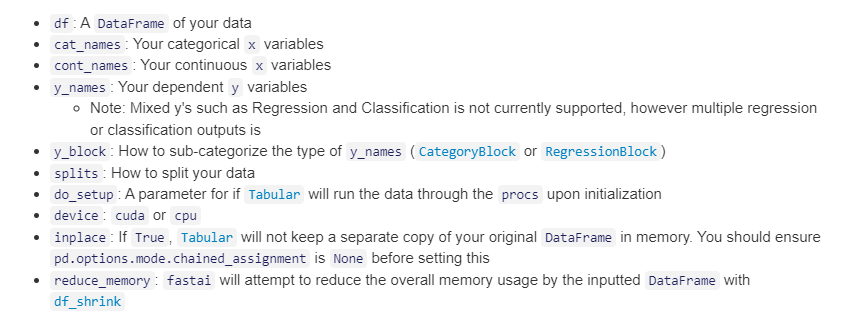

In [ ]:
# splitting criteria - random split with 20% in validation set
splits = RandomSplitter(valid_pct=0.2, seed=1000)(range_of(train_ext_fltr))

tp = TabularPandas(train_ext_fltr, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_feat,
                   cont_names = cont_feat,
                   y_names='Survived',
                   y_block=CategoryBlock(),
                   splits=splits)

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Fillmissing</p>

<div class="alert alert-block alert-success">  

<p>    
<li><b>Fillmissing</b> allows us to handle features with <b>missing values</b></li><br>
<li><b>Fillmissing</b> handles the missing values differently for <b>categorical features</b> and <b>continuos features</b> as discussed below</li>
</p>
    
</div>

- **Categorical Data** 

    - `#na#` is being used for imputing missing values (see `Lifeboat`)
    
    ------------------
- **Continuos Data**    
    - Fastai uses `Median` as default value for imputing the missing continous values
    - You can change the `Median` to `Mean` or `fixed_value`
    - `_na` features are created corresponding to each feature with missing values

    -  <u> code snippet to change imputation strategy </u>

    ```
    fm = FillMissing(fill_strategy=FillStrategy.median)
    to = TabularPandas(df, fm, cont_names=cont_names)
    ```

- **`Categorical Features`**

In [ ]:
tp.show(max_n=3)

- **`Continuos Features`**

In [ ]:
print("filling strategy:",tp.fill_strategy)

In [ ]:
# we can see `_na` are added to cat_feat list
print("we can see that corresponding  _na (bool) features have been added wherever the columns have nulls")
print([col for col in cat_feat if  "_na" in col])

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Normalize</p>

### Fastai normaizes continuos features using `(Xi - Xmean) / Xstd`

> **`Let's check how it happens under the hood`**

In [ ]:
# normalize transform
norms = tp.procs.normalize

In [ ]:
print("Mean/STD for each continuos col")
cont_col_stat = pd.DataFrame([norms.means, norms.stds], index = ["mean","std"])
cont_col_stat

- Let's check for one observation!
    - At `index = 299` the value for Age is `1.528887`
    - We can see that `Age_wiki` is standardized using `(Xi - Xmean) / Xstd`

In [ ]:
# At index = 299 the value for Age_wiki is 1.528887
tp.conts.head(1)

In [ ]:
# Mean & Std for Age feature
age_mean = cont_col_stat["Age_wiki"]["mean"]
age_std = cont_col_stat["Age_wiki"]["std"]

# standardizing age_wiki for 299 index
age_index_299 = train_ext_fltr.loc[299,"Age_wiki"]
age_std = (age_index_299 - age_mean)/age_std

print("Standard Age_wiki using (X-Xmean/Xstd) : ",age_std)

- **Another fun thing!**
    - Can someone tell me why aren't the calculated normalizing means matching when we are calculating means manually ?? `Its easy`

In [ ]:
print("means calculated for normalizing")
display(cont_col_stat.iloc[0].to_frame().T)

print()

print("means calc manually")
display(train_ext[cont_feat].mean().to_frame().T)

- `Hint`

```
t1 = train_ext_fltr.iloc[tp.train.xs.index.tolist()].Age_wiki
t1.fillna(t1.median()).mean()
```

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Embeddings & Categorify</p>

<div class="alert alert-block alert-success">  

<p>    
<li>When dealing with our <b>categorical data</b> ,after the missing-imputation step , <b> Categorify </b> encodes your categories into labels using <b> Label encodings </b></li><br>
<li>We then create what is called an <b> embedding matrix </b> mapped to the encodings . This allows for a higher dimentionality for relationships between the different categorical cardinalities</li>
</p>
    
</div>

### Categorify
> **Transforms columns that are in your `cat_names` into that categorical type, along with `label encoding` our categorical data**

In [ ]:
print("lets look at how label-encodings are done for categorical data \n")
label_encoding_dict = {cat : tp.procs.categorify[cat].o2i for cat in tp.cat_names}


print("label encodings for 'boarded' variable")
label_encoding_dict['Boarded']

- Lets look at how a row at `index 0` in the data is `label-encoded`, use below code
- You can see that the `Boarded` variable for value `Cherbourg` is encoded as `2` which can be verified in the above encodings

In [ ]:
print("encoded data")
display(tp.items.iloc[[0]])

print()

print("original data - categorical values")
row = tp.items.iloc[0]
tp.decode_row(row).to_frame().T

### Emebddings

**Why we need embeddings - we aleardy have encodings!**

- `Ques`: Wait, why we need embeddings now, our categorical data is handled. Isn't it ?
- `Answer`: Not really. `Label encoding` the `nominal-data` can be a problem beacause you are `unnecessarily adding order` to the categories which was never there

-------------------

- `Ques` : Why Embeddings , why not 1-hot encodings ?
- `Ans` : Primarily because Embeddings allow a `better representation (unlike 1-hot encoding)` and are `less sparse` so handling is not an issue

------------------



<div class="alert alert-block alert-success">  

<p>

<b>Embedding size calculation logic</b><br>
The rule is to use either a maximum embedding space of 600, or 1.6 times the cardinality raised to the 0.56 , or written out as:<br>
<li><b> min(600, (1.6 * {var.nunique)}^{0.56})</b></li>
</p>
    
</div>    
    
- Let's calculate these embedding sizes for our model to take a look-see:

In [ ]:
emb_szs = get_emb_sz(tp)

print("Embedding size associated with each categorical feature:\n")
print({k:v for k,v in zip(tp.cat_names,emb_szs)})

**Okay, so ideally the first param should follow `embedding_size == # unique categories`**


- However, you see the counts is 1 more for `Sex`, `Ticket` and `Age_wiki_na` , why ?
    - Honestly, even I dont know but let me try!
    - Ans: The embedding `adds` an additional dimension(category) to handle `potential nulls (#na#)` for columns which have `NOT` seen Nulls 
    
    Ref : https://forums.fast.ai/t/size-of-matrix-in-colab-learner-not-matching/72017/6

In [ ]:
print("# uniques in categorical features")
tp[cat_feat].nunique().to_frame().T

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Dataloader</p>

- Now what's `Dataloader!!`

> PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. 

> **`Dataset stores the samples and their corresponding labels`**, and **`DataLoader wraps an iterable around the Dataset`** to enable easy access to the samples.


--------------

- Okay, but we have **TabDataLoader** and **TabularPandas**

<div class="alert alert-block alert-success">  

<b>TabDataLoader</b> inherits from <b>Dataloader</b> class (is a Dataloader only)

</div>

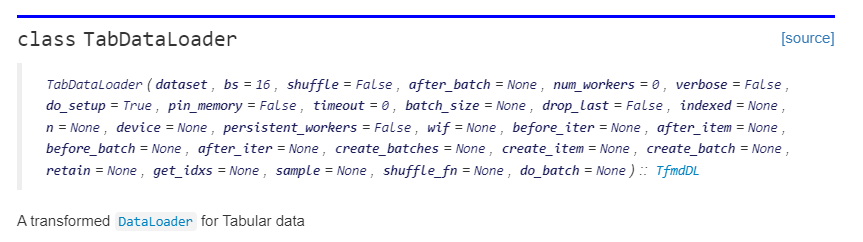



 > Note! : `TabDataLoader` inherits from `TfmdDL` which inturn inherits from `Dataloader` class (pls check source-code)


-------------

<div class="alert alert-block alert-success">  

<p>
<b>TabularPandas</b> : It's a <b>Tabular</b> object with transforms<br>
<li><b>Tabular</b> is a <b>DataFrame wrapper</b> that knows which cols are cont/cat/y, and returns rows in __getitem_</li>
</p>
    
</div>



- **`TabDataloaders`**

In [ ]:
# creating TabDataloaders
trn_dl = TabDataLoader(tp.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(tp.valid, bs=64)

- **`Dataloaders`**

In [ ]:
# creating dataloaders
dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print("Dataloaders is just combining the train and validation TabDataloader")
print(dls.train == trn_dl)

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Tabular Learner</p>

<div class="alert alert-block alert-success">  

<p>    
<li> <b>Fastai</b> uses <b>Tabular learner</b> to initialize the <b>Neural Network</b> </li> <br> 
<li> <b>Tabular learner</b> <b>automatically</b> create a TabularModel suitable for your data and <b>infer the right loss function</b> </li>
</p>
    
</div>

**Learner Params**
    
- Loss : `FlattenedLoss of CrossEntropyLoss()` : what's that. common, just google it!
- Optimizer : `Adam`
    
- Incase you are wondering, how `params #` are calc: just use ``` learn.embeds ``` 

In [ ]:
# lets build the NN with 2 layer - [30, 10 Neurons]
learn = tabular_learner(dls, layers=[30,10], metrics=accuracy)

In [ ]:
# model architecture
learn.summary()

In [ ]:
print("size of embeddings")
print(learn.embeds)

<div class="alert alert-block alert-success">  

<p>    
    
<li><b>lr_find</b> is a real good fastai feature.It lets you find the <b>optimum max_lr</b></li><br>
<li>This is very handy if you are using fasti's <b>fit_one_cycle</b> </li>
</p>    
</div>

> Wanna know more!
[fit_one_cycle & max_lr explained](#fastai_concept)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max = 5e-2)

<a id="fastai_concept"></a> 

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Why LR-max</p>

- As you might have noticed while training the model we called **`fit_one_cycle` & NOT `fit`**


<div class="alert alert-block alert-success">  

<p>    
<li><b>Fit_one_cycle</b> is an appraoch which uses <b>dynamic learning-rate</b> while trainig the model</li><br>
<li>It uses <b>Cyclic learning rate</b> with <b>max_lr (0.05)</b> which we specify as shown below</li> 
</p>
    
</div>

----------------------

I can talk more about `why lr_max` ,`momentum`,`cyclic-lr` or some other `cyclic lr strategy` 

Maybe on a different kernel OR refer to below link!

> *read more about `fit_one_cycle` if you don't know :*
https://sgugger.github.io/the-1cycle-policy.html

> *Learn about `Cyclic learning rates`* 
https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling

### Learning rate - Cyclic Trend

In [ ]:
plt.title("cyclic learning rate")
plt.xlabel("training step")
plt.ylabel("learning rate")
plt.plot(range(len(learn.recorder.lrs)),learn.recorder.lrs)

### Loss Trend

In [ ]:
plt.title("Loss trend")
plt.xlabel("training step")
plt.ylabel("cross-entropy loss")
plt.plot(range(len(learn.recorder.losses)),learn.recorder.losses)

**`Model performance on validation data`**

In [ ]:
# checking validation results
learn.recorder.show_results(max_n = 3)

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">NN architecture [IMP]</p>

- This part is slightly experimentational (basic understanding of `pytorch` is needed) - please bear me for any slight mistakes!😢

- Honestly, I was `not impressed` with the learner part above, thought I should add this too for `interested users`

---------

**Let's talk more about NN architecture - let's go step by step!**

[refer to NN arch.](#NN)

- **STEP 1 :** At the start we have `7 embeddings` layers (explained earlier) for each of our 7 `categorical features` with respective sizes

- **STEP 2:** We also have a `Dropout` with `p == 0`, not sure why ?

- **STEP 3:** We have a `BatchNorm1d` layer of `size = 5`, why? `common you can guess this!!` (BTW do we need BatchNorm for categorical data in this case?)

- **STEP 4:** Then we have a sequential block with multiple  `[Linear, ReLU, Batchnorm]` layers
    - I am not going in as to why we need `Batchnorm` & `ReLU`
    
    - My only question is **why in_features == 168 for the first initial layer ?**
    
    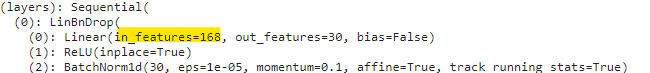
    
    - Let me try: 

        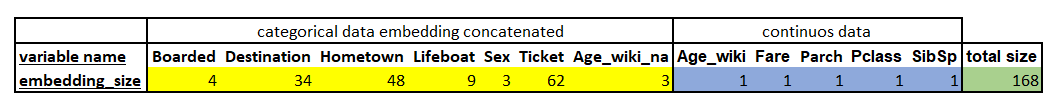

        - This is the step where we are **concatenating** the `categorical data embeddings` and `continuos data` [shown above]        
        
        - let's validate that : 
            if we are concatenating the categorical data embeddings then our column dimension should be
            
            **sum(Embeddings) + 5 (continuos features) == 168** 
            > [The above conition holds true as shown in the code below](#assert)
    
- **STEP 5:** After the 168 neuron Linear layer we have 2 more Linear layers giving 2 values for `binary classification` as `out_features` in the final layer

<a id="NN"></a> 
- `Learner architecture` 

In [ ]:
print("This is how the model's architecture looks! \n")
learn.model

<a id="assert"></a> 
- `Assert if N_cont + N_cat_embed == 168`

In [ ]:
concat_embed_size = sum([x.weight.shape[1] for x in learn.embeds])  # 163 size
n_cont_feat = 5 # continuos data

print("total size of concatenated categorical embeddings and continuos features equals ::",  concat_embed_size + n_cont_feat)

# <p style="background-color:#696969;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Inference</p>

- **Predicting the Test-set**

In [ ]:
# imputing fare with median (coz training data did not have any missings for Fare)
fare_med_val = test_ext_fltr.Fare.median()
test_ext_fltr.loc[:,'Fare'].fillna(fare_med_val, inplace = True)

In [ ]:
t1 = learn.dls.train_ds.new(test_ext_fltr)
t1.process()

dl = TabDataLoader(t1)
preds = learn.get_preds(dl=dl)[0].argmax(1).numpy()

In [ ]:
out = pd.DataFrame({'PassengerId':test_ext.PassengerId, 'Survived': preds.astype(int)})
out.to_csv('submission_1.csv', index=False)
out.head()

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Thanks and Feedback</p>